# <center>Дашборд конверсий</center>

## Импортируем библиотеки

In [3]:
import os
import pandas as pd
import numpy as np
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from dotenv import load_dotenv

## Считаем конверсию

In [5]:
#Получаем данные по визитам и регистрациям

load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

rsp_visit = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
df_visit = pd.DataFrame(rsp_visit.json())

rsp_registrations = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
df_registrations = pd.DataFrame(rsp_registrations.json())

In [7]:
#Группируем данные о визитах по дате и платформе

df_visit_filtered = df_visit[df_visit['platform'] != 'bot']

df_visit_sort = df_visit_filtered.sort_values(by=['visit_id','datetime'], ascending=False)
df_visit_grouped = df_visit_sort.groupby('visit_id').first().reset_index()

df_visit_grouped['datetime'] = pd.to_datetime(df_visit_grouped['datetime']).dt.date

visits = df_visit_grouped[['datetime', 'platform']].groupby(['datetime', 'platform']).size().reset_index(name='visits')

In [8]:
#Группируем данные о регистрациях по дате и платформе

df_registrations_filtered = df_registrations[df_registrations['platform'] != 'bot']

df_registrations_filtered['datetime'] = pd.to_datetime(df_registrations_filtered['datetime']).dt.date

df_registrations_sort = df_registrations_filtered.sort_values(by=['user_id','datetime'], ascending=False)

registrations = df_registrations_sort[['datetime', 'platform']].groupby(['datetime', 'platform']).size().reset_index(name='registrations')

In [9]:
#Соединяем данные о визитах и регистрациях

df_conversion = pd.merge(visits, registrations, on = ['datetime', 'platform'], how='left')
df_conversion = df_conversion.rename(columns={'datetime': 'date_group'})

In [10]:
#Считаем конверсию из визита в регистрацию

df_conversion['conversion'] = df_conversion['registrations'] / df_conversion['visits'] * 100

In [11]:
#Сохраняем данные в файл

df_conversion.to_json('./conversion.json')

## Добавляем данные о рекламных кампаниях

In [8]:
#читаем csv файл с данными о рекламных кампаниях

df_campaign = pd.read_csv('./ads.csv')

In [9]:
#преобразовываем даты в нужный формат

df_campaign['date'] = pd.to_datetime(df_campaign['date']).dt.date

In [10]:
# считаем количество визитов и регистраций по датам

agg_func = {'visits': 'sum', 'registrations': 'sum'}
df_conversion_grouped = df_conversion[['date_group', 'visits', 'registrations']].groupby('date_group').agg(agg_func).reset_index()

In [11]:
#соединяем конверсию и данные по рекламным кампаниям и удаляем ненужные столбцы

df_result = pd.merge(df_conversion_grouped, df_campaign, left_on='date_group', right_on='date', how='left')
df_result.drop(columns=['date', 'utm_source', 'utm_medium'], inplace=True)

In [12]:
#заменяем пустые строки с затратами и названием рекламной кампании

df_result['cost'] = df_result['cost'].fillna(0)
df_result['utm_campaign'] = df_result['utm_campaign'].replace({np.nan: None})

In [13]:
#сохраняем результат в файл

df_result.to_json('./ads.json')

## Строим графики

In [14]:
#создаем директорию, если ее нет

path = './charts'

if not os.path.isdir(path):
    os.makedirs(path)

### Итоговые визиты

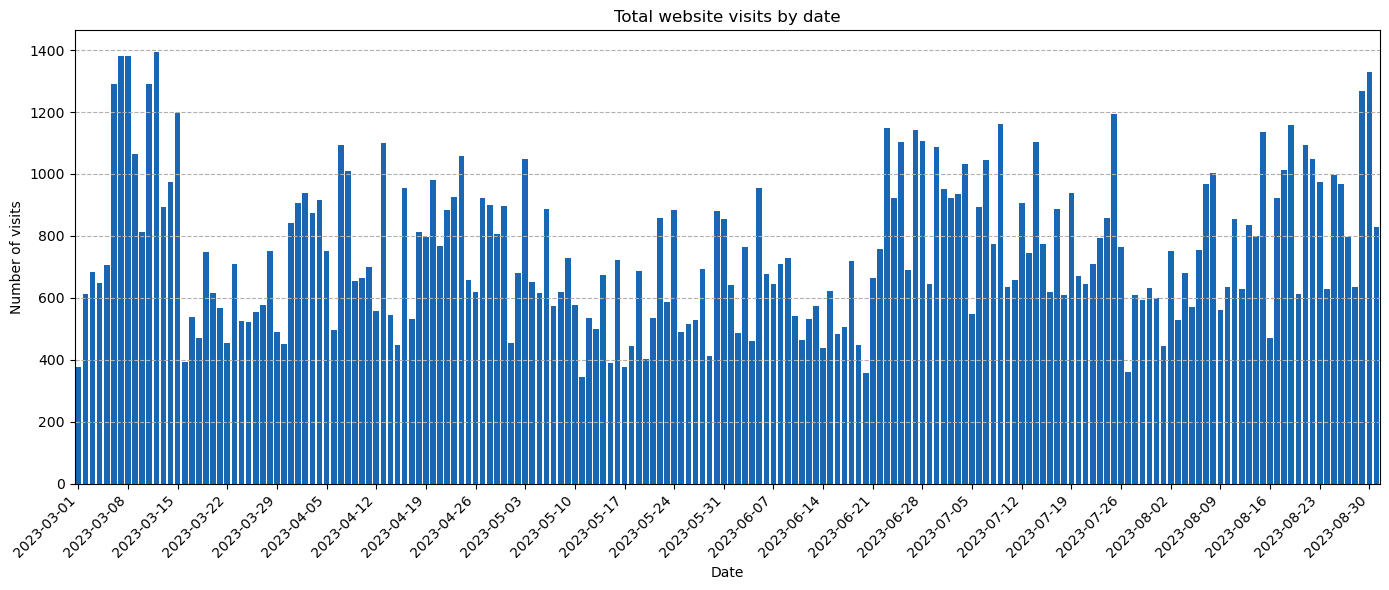

In [15]:
#создаем фигуру
fig, ax = plt.subplots(figsize=(14, 6))

#строим график
sns.barplot(
    data=df_result,
    x="date_group",
    y="visits",
    color='#0066CC',
    ax=ax)

#настраиваем формат подписей тиков по оси x
n = 7
ax.set_xticks(ax.get_xticks()[::n])
plt.xticks(rotation=45, ha='right')

#добавляем подписи
ax.set_title('Total website visits by date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of visits')

#добавляем горизонтальную сетку
ax.grid(axis='y', linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout()

#сохраняем график
plt.savefig('./charts/visits_by_date.png');

### Итоговые визиты с разбивкой по платформам

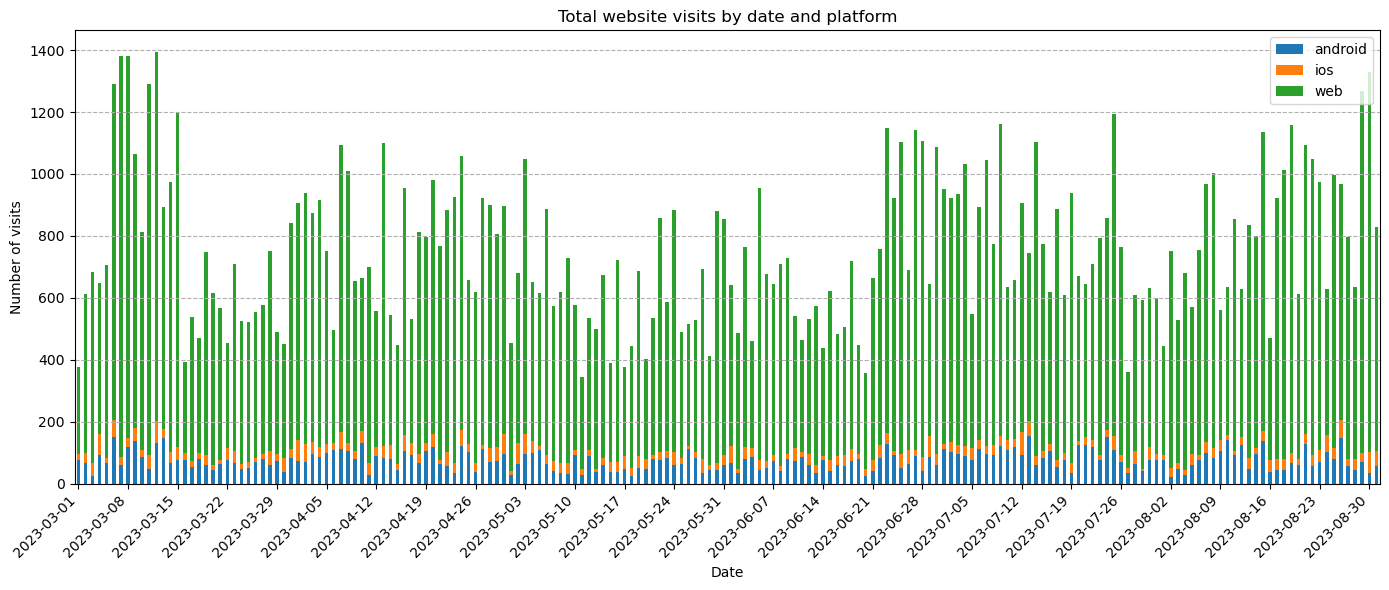

In [16]:
#преобразовываем df
df = df_conversion.pivot(index='date_group', columns='platform', values='visits')

#строим график
ax = df.plot(kind='bar', stacked=True, figsize=(14, 6))

#настраиваем формат подписей тиков по оси x
n = 7
ax.set_xticks(ax.get_xticks()[::n])
plt.xticks(rotation=45, ha='right')

#добавляем подписи
ax.set_title('Total website visits by date and platform')
ax.set_xlabel('Date')
ax.set_ylabel('Number of visits')

#настраиваем легенду
ax.legend(loc='upper right')

#добавляем горизонтальную сетку
ax.grid(axis='y', linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout();

#сохраняем график
plt.savefig('./charts/visits_by_date_and_platform.png');

### Итоговые регистрации

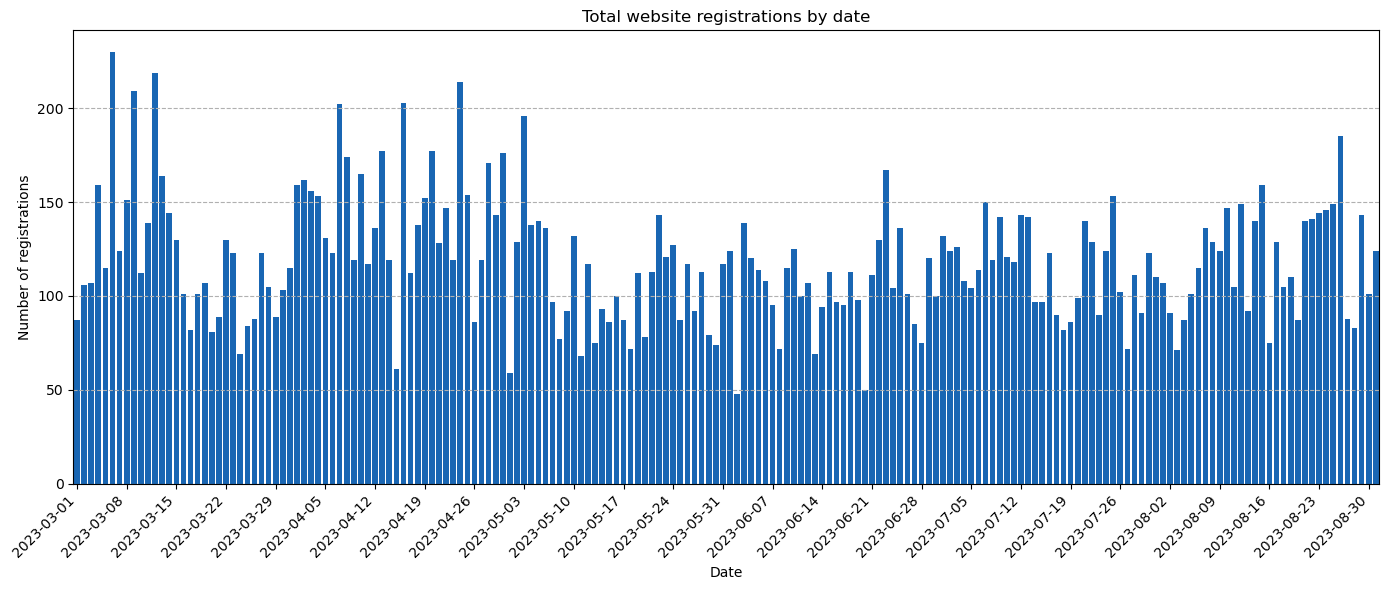

In [17]:
#создаем фигуру
fig, ax = plt.subplots(figsize=(14, 6))

#строим график
sns.barplot(
    data=df_result,
    x="date_group",
    y="registrations",
    color='#0066CC',
    ax=ax)

#настраиваем формат подписей тиков по оси x
n = 7
ax.set_xticks(ax.get_xticks()[::n])
plt.xticks(rotation=45, ha='right')

#добавляем подписи
ax.set_title('Total website registrations by date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of registrations')

#добавляем горизонтальную сетку
ax.grid(axis='y', linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout()

#сохраняем график
plt.savefig('./charts/registrations_by_date.png');

### Итоговые регистрации с разбивкой по платформам

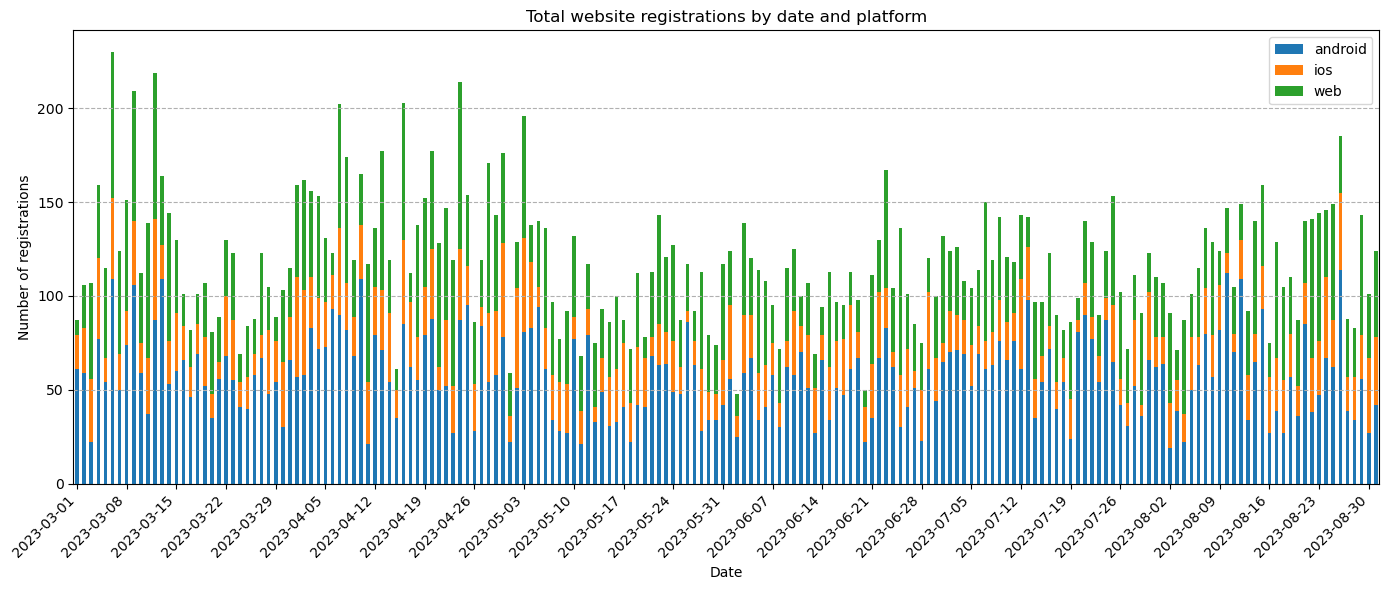

In [18]:
#преобразовываем df
df = df_conversion.pivot(index='date_group', columns='platform', values='registrations')

#строим график
ax = df.plot(kind='bar', stacked=True, figsize=(14, 6))

#настраиваем формат подписей тиков по оси x
n = 7
ax.set_xticks(ax.get_xticks()[::n])
plt.xticks(rotation=45, ha='right')

#добавляем подписи
ax.set_title('Total website registrations by date and platform')
ax.set_xlabel('Date')
ax.set_ylabel('Number of registrations')

#настраиваем легенду
ax.legend(loc='upper right')

#добавляем горизонтальную сетку
ax.grid(axis='y', linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout();

#сохраняем график
plt.savefig('./charts/registrations_by_date_and_platform.png');

### Конверсия по дням

In [19]:
#считаем конверсию в разрезе дней
agg_func = {'visits': 'sum', 'registrations': 'sum'}
df_total_conversion = df_conversion[['date_group', 'visits', 'registrations']].groupby('date_group').agg(agg_func).reset_index()
df_total_conversion['conversion'] = (df_total_conversion['registrations'] / df_total_conversion['visits'] * 100).round().astype(int)

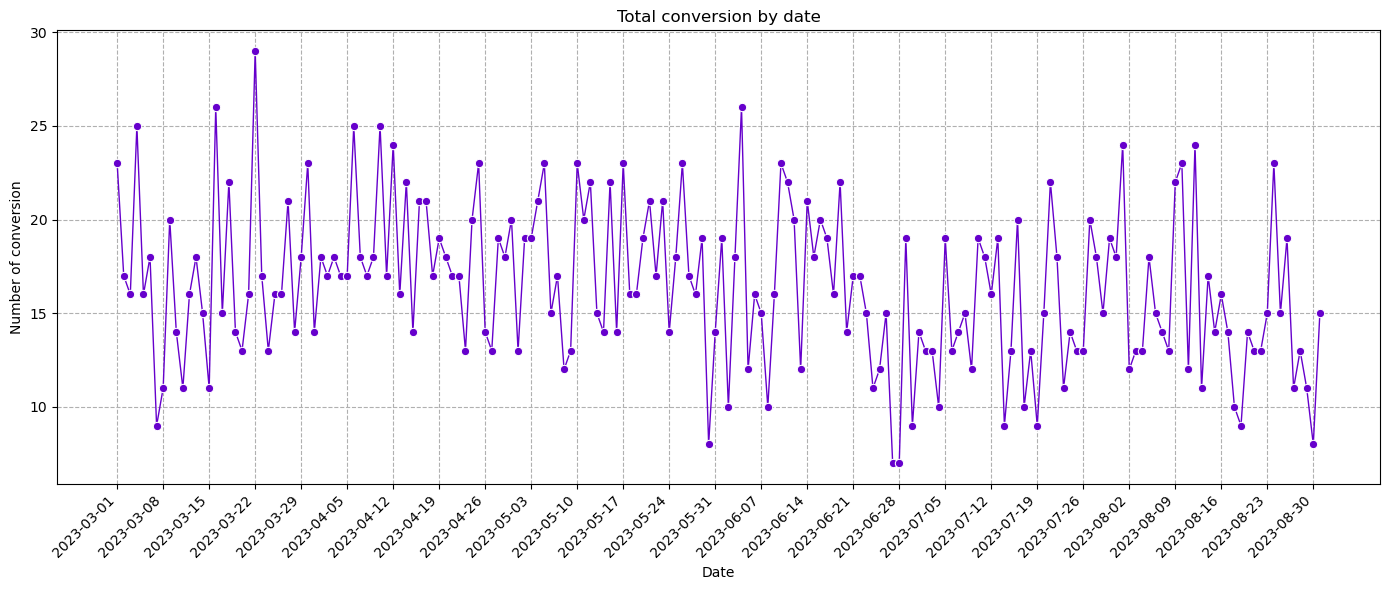

In [20]:
#создаем фигуру
fig, ax = plt.subplots(figsize=(14, 6))

#строим график
sns.lineplot(
    data=df_total_conversion,
    x="date_group",
    y="conversion",
    color='#6600CC',
    linewidth=1,
    marker='o',
    ax=ax)

#настраиваем формат подписей тиков по оси x
ax.set_xticks(df_total_conversion['date_group'])
ax.set_xticklabels(df_total_conversion['date_group'], rotation=45, ha='right')
n = 7
ax.set_xticks(ax.get_xticks()[::n])

#добавляем подписи
ax.set_title('Total conversion by date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of conversion')

#добавляем горизонтальную сетку
ax.grid(linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout()

#сохраняем график
plt.savefig('./charts/conversion_by_date.png');

### Конверсия по каждой платформе

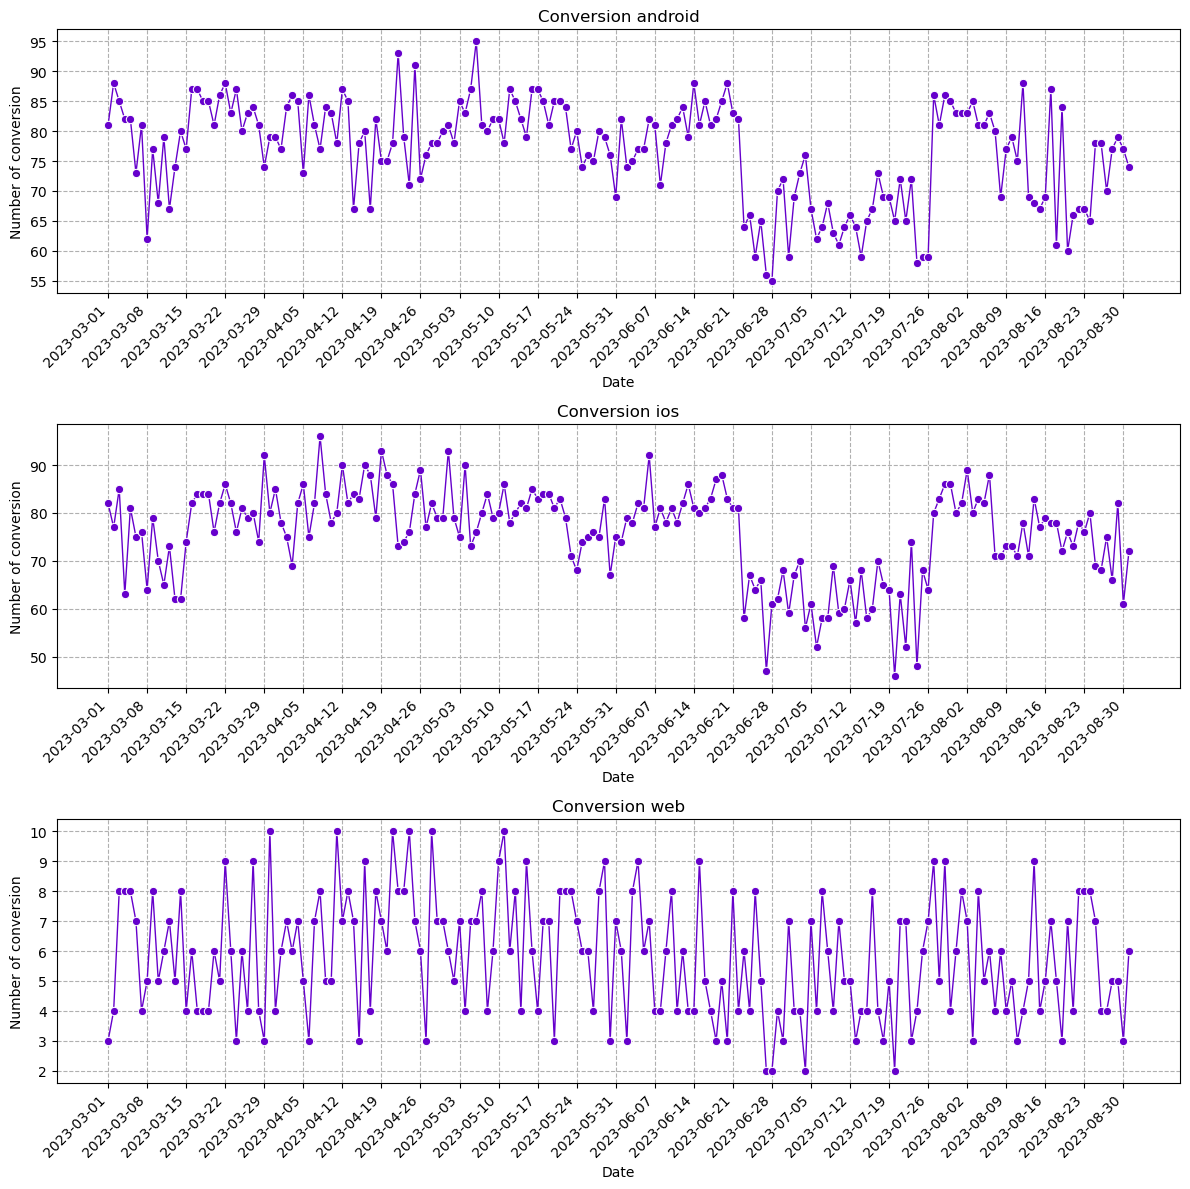

In [21]:
#создаем фигуру
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((12, 12))

#создаем список платформ
platforms = df_conversion['platform'].unique()

for i, platform in enumerate(platforms):
    #фильтруем df
    data = df_conversion[df_conversion['platform']==platforms[i]]

    #строим график
    sns.lineplot(
        data=data,
        x="date_group",
        y="conversion",
        color='#6600CC',
        linewidth=1,
        marker='o',
        ax=ax[i])

    #настраиваем формат подписей тиков по оси x
    ax[i].set_xticks(df_total_conversion['date_group'])
    ax[i].set_xticklabels(df_total_conversion['date_group'], rotation=45, ha='right')
    n = 7
    ax[i].set_xticks(ax[i].get_xticks()[::n])

    #добавляем подписи
    ax[i].set_title(f'Conversion {platform}')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Number of conversion')

    #добавляем горизонтальную сетку
    ax[i].grid(linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout()

#сохраняем график
plt.savefig('./charts/conversion_by_platform.png');

### Стоимости реклам

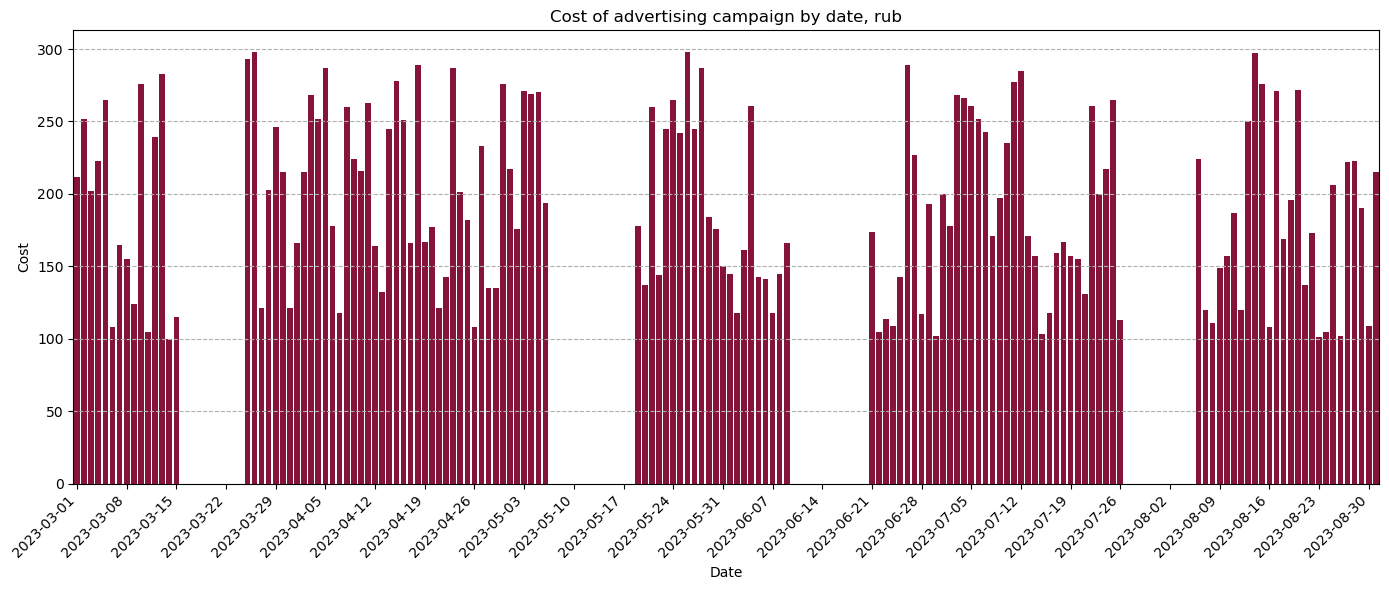

In [22]:
#создаем фигуру
fig, ax = plt.subplots(figsize=(14, 6))

#строим график
sns.barplot(
    data=df_result,
    x="date_group",
    y="cost",
    color='#990033',
    ax=ax)

#настраиваем формат подписей тиков по оси x
n = 7
ax.set_xticks(ax.get_xticks()[::n])
plt.xticks(rotation=45, ha='right')

#добавляем подписи
ax.set_title('Cost of advertising campaign by date, rub')
ax.set_xlabel('Date')
ax.set_ylabel('Cost')

#добавляем горизонтальную сетку
ax.grid(axis='y', linestyle='--')

#настраиваем автоматический подбор отступов
plt.tight_layout()

#сохраняем график
plt.savefig('./charts/cost_by_date.png');

### Визиты и регистрации с выделением рекламных кампаний

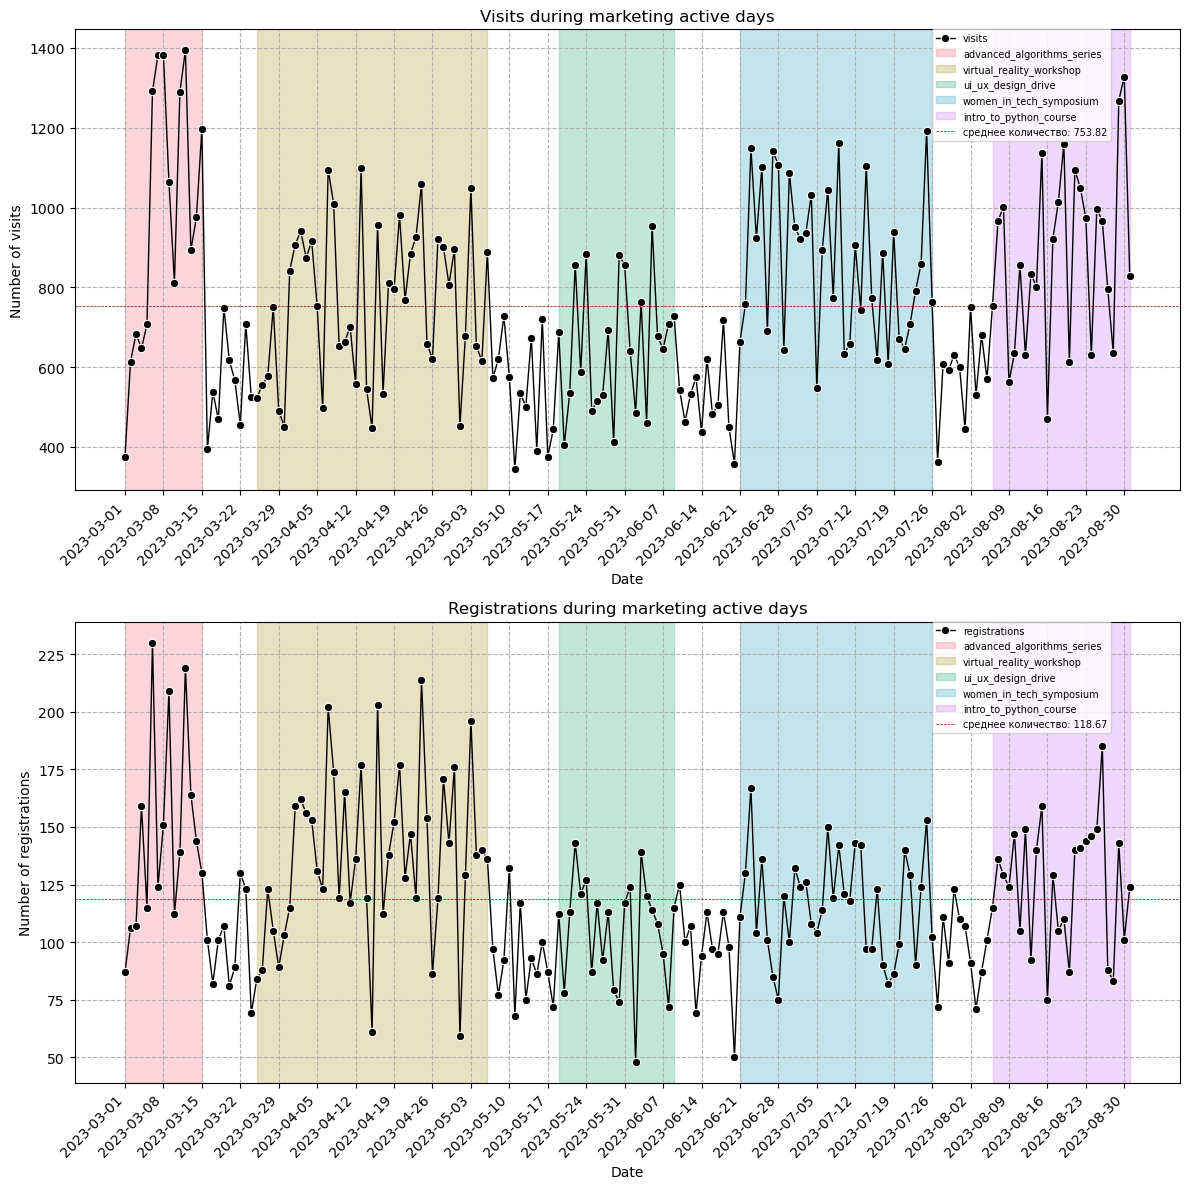

In [23]:
#создаем фигуру
fig, ax = plt.subplots(2, 1)
fig.set_size_inches((12, 12))

#создаем список платформ
interaction = ['visits', 'registrations']

#создаем список компаний и палитру для них
campaigns = df_result.loc[df_result['utm_campaign'].notna(), 'utm_campaign'].unique()
palette = sns.color_palette("husl", len(campaigns))

#создаем цикл для постройки графиков
for i, inter in enumerate(interaction):
    #строим график
    sns.lineplot(
        data=df_result,
        x="date_group",
        y=inter,
        label=inter,
        color='#000000',
        linewidth=1,
        marker='o',
        ax=ax[i])

    #настраиваем формат подписей тиков по оси x
    ax[i].set_xticks(df_total_conversion['date_group'])
    ax[i].set_xticklabels(df_total_conversion['date_group'], rotation=45, ha='right')
    n = 7
    ax[i].set_xticks(ax[i].get_xticks()[::n])

    #добавляем подписи
    ax[i].set_title(f'{inter[0].upper()}{inter[1:]} during marketing active days')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(f'Number of {inter}')

    #добавляем горизонтальную сетку
    ax[i].grid(linestyle='--')

    #закрашиваем области рекламы
    for k, campaign in enumerate(campaigns):
        df_campaign = df_result[df_result['utm_campaign'] == campaign]
        date_min = df_campaign['date_group'].min()
        date_max = df_campaign['date_group'].max()
        ax[i].axvspan(date_min, date_max, alpha=0.3, label=campaign, color=palette[k])

    #добавляем линию среднего значения
    mean_tip = df_result[inter].mean()
    ax[i].axhline(mean_tip, color='darkred', linestyle='--', linewidth=0.5, label=f'среднее количество: {mean_tip:.2f}')
    
    #добавляем легенду
    ax[i].legend(
        fontsize=7,
        facecolor='white',
        loc='upper right',
        bbox_to_anchor=(0.942, 1.011))

#настраиваем автоматический подбор отступов
plt.tight_layout()

#сохраняем график
plt.savefig('./charts/visit_and_registration_with_campaigns_highlighted.png');